In [1]:
import re, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *

from fastai.tabular import *
from fastai.tabular.all import *
from fastai.tabular.data import *
from fastai.tabular.learner import *
from fastai.metrics import *

In [4]:
data = pd.read_csv("data_shuf.csv")
alist = data.columns.to_list()
alist

['city_id',
 'land_cover',
 'pop2012',
 'X',
 'Y',
 'road_len',
 'night2012',
 'cen_dist',
 'dem',
 'city_pop_total']

In [5]:
data.describe()

,city_id,land_cover,pop2012,X,Y,road_len,night2012,cen_dist,dem,city_pop_total
count,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000
mean,43.818316,6.906518,0.008004,0.502616,0.501277,0.071480,0.020648,0.214999,0.094664,0.192048
std,22.376779,1.857292,0.032205,0.230683,0.231005,0.093311,0.042011,0.142153,0.111697,0.301218
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,7.000000,0.000000,0.322222,0.319149,0.000000,0.001736,0.115120,0.018639,0.021847
50%,44.000000,7.000000,0.000061,0.500000,0.500000,0.046930,0.004673,0.182038,0.054225,0.036372
75%,65.000000,8.000000,0.001265,0.684982,0.683673,0.104343,0.017724,0.279313,0.126239,0.141055
max,83.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
cat_names = alist[1]
cont_names = alist[3:]
y_names = alist[2]
procs = [Categorify,]

In [7]:
splits = RandomSplitter(valid_pct=0.2)(range_of(data))

In [8]:
cont,cat = cont_cat_split(data, 1, dep_var=y_names)
to = TabularPandas(data, procs, cat, cont, y_names=y_names, splits=splits)

In [9]:
len(to.train),len(to.valid)

(347020, 86754)

In [10]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Decision Tree

In [11]:
m = DecisionTreeRegressor(max_leaf_nodes=4, min_samples_leaf=25)
m.fit(xs, y);

In [12]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [13]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.020876, 0.020881)

In [14]:
m.get_n_leaves(), len(xs)

(4, 347020)

## Random Forest

In [15]:
n_estimators = 500
max_samples = 200_000
max_features = 0.5
min_samples_leaf = 5

rf = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
    max_samples=max_samples, max_features=max_features,
    min_samples_leaf=min_samples_leaf, oob_score=True)

In [16]:
m = rf.fit(xs, y);

In [17]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.01156, 0.014114)

In [18]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
rmse = r_mse(preds.mean(0), valid_y)
rmse

0.014114

In [19]:
std = data.describe().to_dict()['pop2012']['std']
R2 = 1 - ( rmse / std ) ** 2
R2

0.8079303008410866

In [20]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

(500, 86754)

In [21]:
preds_std = preds.std(0)
preds_std[:5]

array([6.77678545e-03, 4.61718479e-03, 8.19840538e-05, 8.27865868e-04, 9.91529960e-05])

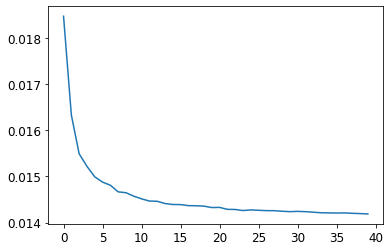

In [22]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

## Now Prediction!

In [23]:
# Save the model
name = 'Forest'


In [24]:
# predict with the model
data = pd.read_csv("data_new.csv")
alist = data.columns.to_list()
cat_names = alist[1]
cont_names = alist[3:]
y_names = alist[2]
procs = [Categorify,]
cont,cat = cont_cat_split(data, 1, dep_var=y_names)
to = TabularPandas(data, procs, cat, cont, y_names=y_names, splits=splits)
xs, y = to.x, to.y

AttributeError: x

In [ ]:
pred = rf(xs, y)

In [ ]:
# Transform to the pre-normalized state
maxi = 57586.267532
pred = pred * maxi

In [ ]:
# Copy in the csv
data = pd.read_csv("data.csv")
data['pop_pred'] = pred

In [ ]:
data.to_csv("data.csv",index=False)
print('File Exported!')